# Empirical Analysis of Aid Interventions

To assess the practical utility of our correction methods in a setting where the true treatment effect is unknown, we construct an evaluation framework based on real-world development projects. This notebook goes through this process.

In [1]:
import os
import pandas as pd
import re
import numpy as np
import itertools
import configparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

tqdm.pandas()

sns.set_style("whitegrid")

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']
MAPBOX_TOKEN = config['ACCESS TOKENS']['MAPBOX']

RANDOM_STATE = 42

# Set seeds
np.random.seed(RANDOM_STATE)

Load data

In [3]:
aid_data_dir = os.path.join(DATA_DIR, 'aid_data')
interventions_df = pd.read_csv(os.path.join(aid_data_dir, 'interim/interventions.csv'))
interventions_dhs_link_df = pd.read_csv(os.path.join(aid_data_dir, 'interim/intervention_dhs_link.csv'))

# Define the directories for end-to-end models
MODELS_DIR = os.path.join(DATA_DIR, 'models', 'mse_num_top_epochs=0_num_full_epochs=20')
RATLEDGE_MODELS_DIR = os.path.join(DATA_DIR, 'models', 'ratledge_lambda_b=15.0_num_top_epochs=0_num_full_epochs=20')

folds = ['A', 'B', 'C', 'D', 'E']

# Load the dataset with MSE predictions
if not os.path.exists(MODELS_DIR):
    raise FileNotFoundError(f"Models directory not found at {MODELS_DIR}")
dhs_df = pd.read_csv(os.path.join(MODELS_DIR, 'dhs_with_imgs_predictions.csv'))
with open(os.path.join(MODELS_DIR, 'correction_values.json'), 'r') as f:
    correction_values = json.load(f)

# Load the dataset with Ratledge predictions
if not os.path.exists(RATLEDGE_MODELS_DIR):
    raise FileNotFoundError(f"Ratledge models directory not found at {RATLEDGE_MODELS_DIR}")
ratledge_df = pd.read_csv(os.path.join(RATLEDGE_MODELS_DIR, 'dhs_with_imgs_predictions.csv'))

# Check if the CV folds and Cluster IDs match:
if not (dhs_df['cv_fold'] == ratledge_df['cv_fold']).all() or not (dhs_df['cluster_id'] == ratledge_df['cluster_id']).all():
    raise ValueError("CV folds in the two datasets do not match.")

# Add the Ratledge predictions to the DHS DataFrame
dhs_df['ratledge_iwi_hat'] = ratledge_df['iwi_hat']
del ratledge_df  # Free memory

In [4]:
dhs_df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,cv_fold,iwi_hat,train_score,val_score,ratledge_iwi_hat
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459,C,55.702774,-0.016650,-0.029015,46.782425
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589,B,20.174559,-0.103994,-0.080675,19.756855
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211,E,61.692880,-0.035819,-0.034696,45.635110
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697,B,30.861835,-0.033717,-0.040645,33.495945
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944,B,13.032152,0.150912,0.174642,13.222273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68614,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567,C,23.805214,-0.088216,-0.085859,24.828403
68615,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878,D,26.511787,-0.067005,-0.065943,26.584358
68616,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326,A,17.585537,-0.043897,-0.021347,18.933214
68617,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344,C,51.239365,-0.008125,-0.014604,49.562950


## Downstream: Analyze Intervention

In [5]:
ad_sector_code = 430
funder = 'CH'

intervention_df = interventions_df[(interventions_df['ad_sector_codes'] == ad_sector_code) & (interventions_df['funder'] == funder)]

In [6]:
interventions_dhs_link_df

,project_location_id,cluster_id,years_since_intervention
0,31023_11550981,KE.Baringo.8B.1033,9.412924
1,31023_11550981,KE.Baringo.8B.1034,9.412924
2,31023_11550981,KE.Baringo.8B.1053,9.412924
3,31023_11550981,KE.Baringo.8B.1054,9.495062
4,31023_11550981,KE.Rift Valley.72.1155,1.664647
...,...,...,...
266575,P091077_328649,ET.Affar.81.35,11.589560
266576,P091077_328649,ET.Affar.81.36,11.589560
266577,P091077_328649,ET.Affar.81.37,11.589560
266578,P091077_328649,ET.Affar.81.38,11.589560


In [7]:
intervention_location_ids = intervention_df['project_location_id'].unique()

intervention_dhs_link_df = interventions_dhs_link_df[interventions_dhs_link_df['project_location_id'].isin(intervention_location_ids)]
valid_dhs_clusters = intervention_dhs_link_df[['cluster_id', 'years_since_intervention']].drop_duplicates()

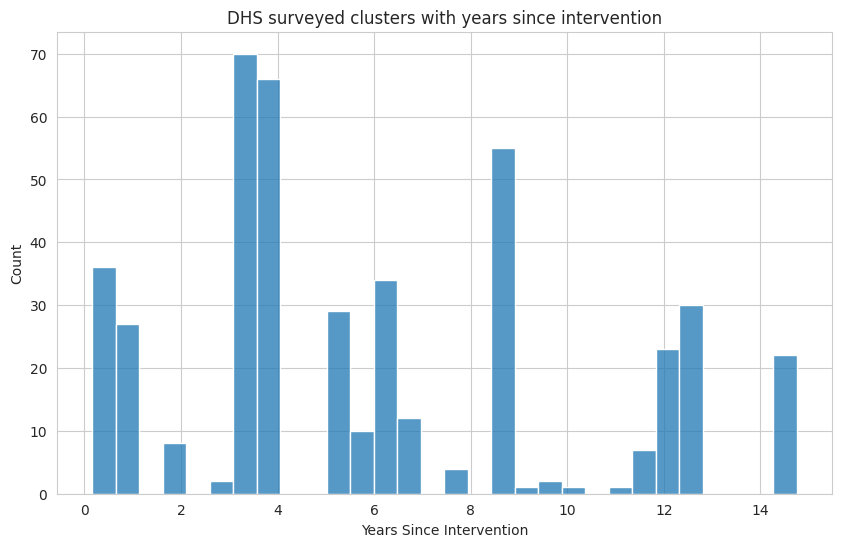

In [8]:
# Plot a histogram of the years since intervention
plt.figure(figsize=(10, 6))
sns.histplot(data=valid_dhs_clusters, x='years_since_intervention', bins=30)
plt.title('DHS surveyed clusters with years since intervention')
plt.xlabel('Years Since Intervention')
plt.ylabel('Count')
plt.show()

Get treated clusters

In [10]:
# The maximum and minimum years since the intervention start that we want to include to count as treated
min_years = 3
max_years = 8

valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(min_years, max_years)]['cluster_id'].unique()
treated_clusters_ixs = dhs_df['cluster_id'].isin(valid_dhs_cluster_ids)
treated_df = dhs_df[treated_clusters_ixs]

Choose control samples as the remaining clusters of surveys that are included in the treatment set

In [12]:
surveys_in_treated_df = treated_df['survey'].unique()
control_clusters_ixs = (dhs_df['survey'].isin(surveys_in_treated_df)) & ~treated_clusters_ixs
control_df = dhs_df[control_clusters_ixs]

In [13]:
treated_df.loc[:, 'status'] = 'Treated'
control_df.loc[:, 'status'] = 'Control'

trial_df = pd.concat([treated_df, control_df], axis=0)

trial_df

/local/tmp.4856116/ipykernel_125083/4269914082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_df.loc[:, 'status'] = 'Treated'
/local/tmp.4856116/ipykernel_125083/4269914082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_df.loc[:, 'status'] = 'Control'


,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi,cv_fold,iwi_hat,train_score,val_score,ratledge_iwi_hat,status
4833,BU.Bujumbura.61.159,29.388832,-3.378821,False,BU.Bujumbura,Burundi,Burundi 2010 Standard DHS,1,2011,76.092778,E,41.792970,0.000538,-0.004122,53.252563,Treated
29851,LB.Monrovia.61.100,-10.768341,6.328796,False,LB.Monrovia,Liberia,Liberia 2011 MIS,9,2011,37.696076,D,30.842108,-0.031627,-0.043814,43.835087,Treated
29852,LB.Monrovia.61.101,-10.747136,6.354223,False,LB.Monrovia,Liberia,Liberia 2011 MIS,9,2011,40.995968,C,38.272255,-0.009613,-0.002788,42.119873,Treated
29853,LB.Monrovia.61.102,-10.768001,6.362465,False,LB.Monrovia,Liberia,Liberia 2011 MIS,9,2011,26.718666,B,47.502342,0.005657,0.003502,50.509434,Treated
29854,LB.Monrovia.61.103,-10.793270,6.365558,False,LB.Monrovia,Liberia,Liberia 2011 MIS,9,2011,30.914220,D,32.416138,-0.026478,-0.037666,40.819110,Treated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67164,ZM.Western.61.721,23.462544,-16.016171,True,ZM.Western,Zambia,Zambia 2013-14 Standard DHS,9,2013,9.186889,E,13.559130,0.100709,0.122798,7.163624,Control
67165,ZM.Western.61.81,22.164573,-15.035946,False,ZM.Western,Zambia,Zambia 2013-14 Standard DHS,10,2013,22.461579,A,13.085678,0.188899,0.185976,0.498787,Control
67166,ZM.Western.61.83,24.841707,-14.792199,False,ZM.Western,Zambia,Zambia 2013-14 Standard DHS,1,2014,28.146865,C,20.180714,-0.086306,-0.060840,10.841841,Control
67167,ZM.Western.61.92,23.314204,-15.954686,True,ZM.Western,Zambia,Zambia 2013-14 Standard DHS,11,2013,12.109986,A,17.384870,-0.035855,-0.014127,24.307093,Control


In [14]:
from mapboxgl.utils import df_to_geojson, create_color_stops
from mapboxgl.viz import CircleViz

# Convert dataframe to GeoJSON
geojson = df_to_geojson(
    trial_df,
    lat='lat',
    lon='lon',
    properties=['status'],
)

# Create color stops for the map
color_stops = [
    ['Treated', 'rgb(256,0,0)'],  # Red for treated
    ['Control', 'rgb(0,0,256)'],  # Blue for control
]
# Create a CircleViz object
viz = CircleViz(
    geojson,
    access_token=MAPBOX_TOKEN,
    color_property='status',
    color_stops=color_stops,
    color_function_type='match',
    radius=5,
    opacity=0.8,
    stroke_color='#000000',
    stroke_width=1,
)
viz.show()

/opt/conda/lib/python3.8/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Get the ATE without any propensity weighting

In [15]:
ate = treated_df['iwi'].mean() - control_df['iwi'].mean()
ate_hat = treated_df['iwi_hat'].mean() - control_df['iwi_hat'].mean()

print(f'ATE: {ate:.4f}')
print(f'ATE hat: {ate_hat:.4f}')

ATE: 26.7430
ATE hat: 25.0642


## Run for all treatments

In [16]:
trials_df = interventions_df[['funder', 'ad_sector_codes']].drop_duplicates().reset_index(drop=True)

ad_sector_names = {
    #Social Infrastructure & Services
    110: "Education",
    120: "Health",
    130: "Population Policies / Programmes and Reproductive Health",
    140: "Water Supply and Sanitation",
    150: "Government and Civil Society",
    160: "Other Social Infrastructure and Services",
    # Economic Infrastructure & Services 
    210: "Transport and Storage",
    220: "Communications",
    230: "Energy Generation and Supply",
    240: "Banking and Financial Services",
    250: "Business and Other Services",
    # Production
    310: "Agriculture, Forestry and Fishing",
    320: "Industry, Mining, Construction",
    330: "Trade and Tourism",
    # Direct Aid
    520: "Developmental Food Aid/Food Security Assistance",
    700: "Emergency Response",
    600: "Action Relating to Debt",
    920: "Support to Non-governmental Organizations (NGOs) and Government Organizations",
    530: "Non-food commodity assistance",
    # Other
    410: "General Environment Protection",
    420: "Women in Development",
    430: "Other Multisector",
    998: "Unallocated / Unspecified"
}

trials_df['ad_sector_names'] = trials_df['ad_sector_codes'].map(ad_sector_names)

trials_df

,funder,ad_sector_codes,ad_sector_names
0,CH,230,Energy Generation and Supply
1,CH,220,Communications
2,CH,210,Transport and Storage
3,CH,110,Education
4,CH,150,Government and Civil Society
5,CH,320,"Industry, Mining, Construction"
6,CH,310,"Agriculture, Forestry and Fishing"
7,CH,120,Health
8,CH,520,Developmental Food Aid/Food Security Assistance
9,CH,140,Water Supply and Sanitation


In [17]:
def get_PPI_ATE(treated_df, control_df, labeled_frac=0.1):
    """
    Calculate the ATE with PPI (Prediction Powered Inference) between treated and control groups.
    """

    # Sample a fraction of the treated and control groups to use as the "fresh" labeled data
    n_samples = len(treated_df) + len(control_df)
    sample_ixs = np.random.choice(np.arange(n_samples), size=int(n_samples * labeled_frac), replace=False)
    treated_sample_ixs = sample_ixs[sample_ixs < len(treated_df)]
    control_sample_ixs = sample_ixs[sample_ixs >= len(treated_df)] - len(treated_df)

    labeled_treated_df = treated_df.iloc[treated_sample_ixs]
    labeled_control_df = control_df.iloc[control_sample_ixs]
    
    # Use the remaining data as unlabeled
    unlabeled_treated_df = treated_df.drop(labeled_treated_df.index)
    unlabeled_control_df = control_df.drop(labeled_control_df.index)

    # Get the biases with the labeled data
    treated_bias = (labeled_treated_df['iwi'] - labeled_treated_df['iwi_hat']).mean()
    control_bias = (labeled_control_df['iwi'] - labeled_control_df['iwi_hat']).mean()

    ppi_ate = (treated_df['iwi_hat'].mean() - control_df['iwi_hat'].mean()) + (treated_bias - control_bias)
    return ppi_ate

def get_LCC_ATE(treated_df, control_df, correction_values):

    treated_mean = treated_df.apply(lambda row: row['iwi_hat'] / correction_values[row['cv_fold']]['val_lcc_slope'], axis=1).mean()
    control_mean = control_df.apply(lambda row: row['iwi_hat'] / correction_values[row['cv_fold']]['val_lcc_slope'], axis=1).mean()
    lcc_ate = treated_mean - control_mean
    return lcc_ate

def get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='train_sigma', score_name='train_score'):

    treated_preds = treated_df.apply(lambda row: row['iwi_hat'] - correction_values[row['cv_fold']][sigma_name]**2 * row[score_name], axis=1)
    control_preds = control_df.apply(lambda row: row['iwi_hat'] - correction_values[row['cv_fold']][sigma_name]**2 * row[score_name], axis=1)

    tweedie_ate = treated_preds.mean() - control_preds.mean()
    return tweedie_ate


In [18]:
def get_ates_of_trial(row, interventions_df, dhs_df):
    ad_sector_code = row['ad_sector_codes']
    funder = row['funder']

    intervention_df = interventions_df[(interventions_df['ad_sector_codes'] == ad_sector_code) & (interventions_df['funder'] == funder)]

    intervention_location_ids = intervention_df['project_location_id'].unique()

    intervention_dhs_link_df = interventions_dhs_link_df[interventions_dhs_link_df['project_location_id'].isin(intervention_location_ids)]
    valid_dhs_clusters = intervention_dhs_link_df[['cluster_id', 'years_since_intervention']].drop_duplicates()

    # The maximum and minimum years since the intervention start that we want to include to count as treated
    min_years = 3
    max_years = 8

    valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(min_years, max_years)]['cluster_id'].unique()
    treated_clusters_ixs = dhs_df['cluster_id'].isin(valid_dhs_cluster_ids)
    treated_df = dhs_df[treated_clusters_ixs]

    surveys_in_treated_df = treated_df['survey'].unique()
    control_clusters_ixs = (dhs_df['survey'].isin(surveys_in_treated_df)) & ~treated_clusters_ixs
    control_df = dhs_df[control_clusters_ixs]

    ate = treated_df['iwi'].mean() - control_df['iwi'].mean()
    ate_hat = treated_df['iwi_hat'].mean() - control_df['iwi_hat'].mean()
    ratledge_ate = treated_df['ratledge_iwi_hat'].mean() - control_df['ratledge_iwi_hat'].mean()
    ppi_ate = get_PPI_ATE(treated_df, control_df, labeled_frac=0.1)
    lcc_ate = get_LCC_ATE(treated_df, control_df, correction_values)
    tweedie_ate_train_train = get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='train_sigma', score_name='train_score')
    tweedie_ate_train_val = get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='train_sigma', score_name='val_score')
    tweedie_ate_val_train = get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='val_sigma', score_name='train_score')
    tweedie_ate_val_val = get_Tweedie_ATE(treated_df, control_df, correction_values, sigma_name='val_sigma', score_name='val_score')

    row['ate'] = ate
    row['ate_hat'] = ate_hat
    row['ratledge_ate'] = ratledge_ate
    row['ppi_ate'] = ppi_ate
    row['lcc_ate'] = lcc_ate
    row['tweedie_ate_train_train'] = tweedie_ate_train_train
    row['tweedie_ate_train_val'] = tweedie_ate_train_val
    row['tweedie_ate_val_train'] = tweedie_ate_val_train
    row['tweedie_ate_val_val'] = tweedie_ate_val_val
    row['treated_count'] = len(treated_df)
    row['control_count'] = len(control_df)
    return row

# Apply the function to each row of the trials_df
out_trials_df = trials_df.progress_apply(get_ates_of_trial, axis=1, interventions_df=interventions_df, dhs_df=dhs_df)

100%|██████████| 34/34 [00:26<00:00,  1.27it/s]


In [19]:
dhs_df[['cluster_id', 'lon', 'lat', 'rural', 'region_id', 'country', 'survey', 'month', 'year', 'iwi']]

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
68614,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
68615,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
68616,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
68617,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


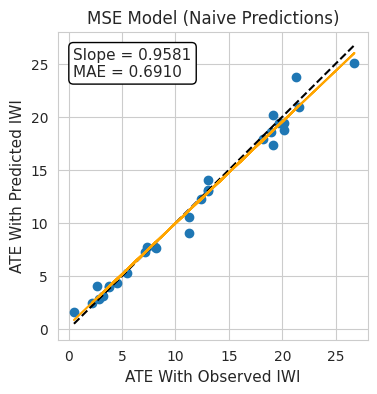

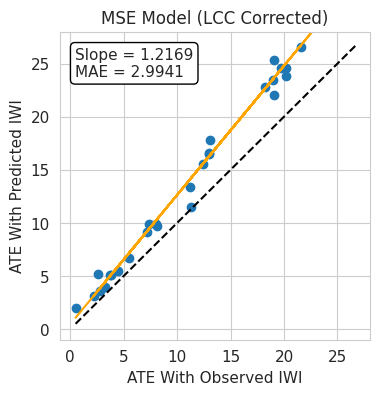

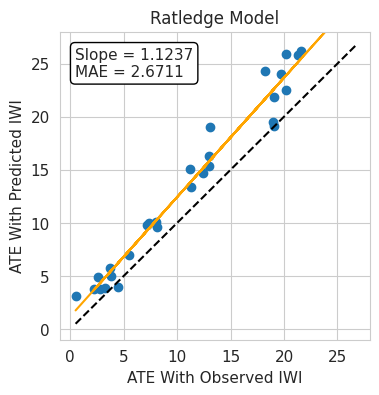

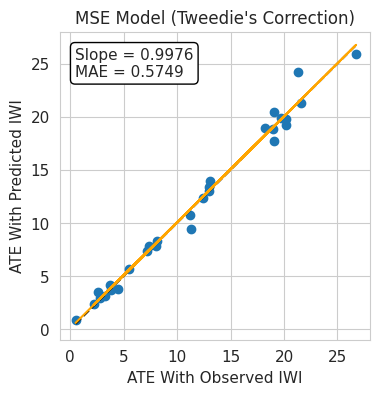

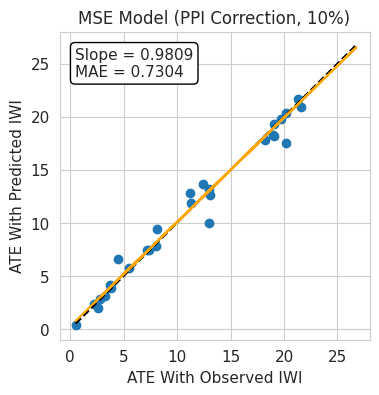

In [21]:
from sklearn.linear_model import LinearRegression

def plot_ate_scatter(out_trials_df, predicted_col, title, axis_min=-1, axis_max=28):

    min_ate = out_trials_df['ate'].min()
    max_ate = out_trials_df['ate'].max()
    plt.plot([min_ate, max_ate], [min_ate, max_ate], 'k--')

    plt.scatter(out_trials_df['ate'].values, out_trials_df[predicted_col].values.astype(float))
    # Add label with slope and MAE to plot
    # slope, _ = np.polyfit(out_trials_df['ate'].values, out_trials_df[predicted_col].values.astype(float), 1)
    slope_model = LinearRegression().fit(out_trials_df['ate'].values.reshape(-1, 1), out_trials_df[predicted_col])
    slope = slope_model.coef_[0]
    mae = mean_absolute_error(out_trials_df['ate'].values, out_trials_df[predicted_col].values)
    plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    plt.plot(out_trials_df['ate'], slope_model.predict(out_trials_df['ate'].values.reshape(-1, 1)), color='orange')
    
    font_size = 11
    plt.xlabel('ATE With Observed IWI', fontsize=font_size)
    plt.ylabel('ATE With Predicted IWI', fontsize=font_size)
    plt.rc('xtick', labelsize=font_size)
    plt.rc('ytick', labelsize=font_size)
    plt.title(title)

    if axis_min is not None and axis_max is not None:
        plt.xlim(axis_min, axis_max)
        plt.ylim(axis_min, axis_max)

# Plot the ATEs
plot_df = out_trials_df[out_trials_df['treated_count'] > 20]

axis_min = -1
axis_max = 28

plt.figure(figsize=(4, 4))
plot_ate_scatter(plot_df, 'ate_hat', "MSE Model (Naive Predictions)")
plt.savefig('figures/mse_hat_ate_scatter.png', bbox_inches='tight', dpi=300)

plt.figure(figsize=(4, 4))
plot_ate_scatter(plot_df, 'lcc_ate', "MSE Model (LCC Corrected)")
plt.savefig('figures/mse_lcc_ate_scatter.png', bbox_inches='tight', dpi=300)

plt.figure(figsize=(4, 4))
plot_ate_scatter(plot_df, 'ratledge_ate', "Ratledge Model")
plt.savefig('figures/ratledge_ate_scatter.png', bbox_inches='tight', dpi=300)

plt.figure(figsize=(4, 4))
plot_ate_scatter(plot_df, 'tweedie_ate_train_train', "MSE Model (Tweedie's Correction)")
plt.savefig('figures/mse_tweedie_ate_scatter.png', bbox_inches='tight', dpi=300)

plt.figure(figsize=(4, 4))
plot_ate_scatter(plot_df, 'ppi_ate', "MSE Model (PPI Correction, 10%)")
plt.savefig('figures/mse_ppi_ate_scatter.png', bbox_inches='tight', dpi=300)

# Compare with PPI

In [22]:
def get_ppi_resids_of_trial(row, interventions_df, dhs_df):
    ad_sector_code = row['ad_sector_codes']
    funder = row['funder']

    intervention_df = interventions_df[(interventions_df['ad_sector_codes'] == ad_sector_code) & (interventions_df['funder'] == funder)]

    intervention_location_ids = intervention_df['project_location_id'].unique()

    intervention_dhs_link_df = interventions_dhs_link_df[interventions_dhs_link_df['project_location_id'].isin(intervention_location_ids)]
    valid_dhs_clusters = intervention_dhs_link_df[['cluster_id', 'years_since_intervention']].drop_duplicates()

    # The maximum and minimum years since the intervention start that we want to include to count as treated
    min_years = 3
    max_years = 8

    valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(min_years, max_years)]['cluster_id'].unique()
    treated_clusters_ixs = dhs_df['cluster_id'].isin(valid_dhs_cluster_ids)
    treated_df = dhs_df[treated_clusters_ixs]

    surveys_in_treated_df = treated_df['survey'].unique()
    control_clusters_ixs = (dhs_df['survey'].isin(surveys_in_treated_df)) & ~treated_clusters_ixs
    control_df = dhs_df[control_clusters_ixs]

    ate = treated_df['iwi'].mean() - control_df['iwi'].mean()

    # Calculate the PPI ATE with different hold-out fractions
    hold_out_fracs = np.linspace(0.01, 1.0, 50)
    for frac in hold_out_fracs:
        ppi_res = []
        for i in range(50):
            ppi_res.append(np.abs(ate - get_PPI_ATE(treated_df, control_df, labeled_frac=frac)))
        ppi_res = np.mean(ppi_res)
        row[frac] = ppi_res  # np.abs(ate - ppi_ate)


    row['treated_count'] = len(treated_df)
    row['control_count'] = len(control_df)
    return row

# Apply the function to each row of the trials_df
ppi_trials_df = trials_df.progress_apply(get_ppi_resids_of_trial, axis=1, interventions_df=interventions_df, dhs_df=dhs_df)

100%|██████████| 34/34 [03:21<00:00,  5.94s/it]


/local/tmp.4813516/ipykernel_737344/2709392648.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ppi_trials_stats = ppi_trials_df.drop(columns=['funder', 'ad_sector_codes', 'treated_count', 'control_count']).mean().reset_index()
/local/tmp.4813516/ipykernel_737344/2709392648.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var = ppi_trials_df.drop(columns=['funder', 'ad_sector_codes', 'treated_count', 'control_count']).var().values


<Figure size 400x400 with 0 Axes>

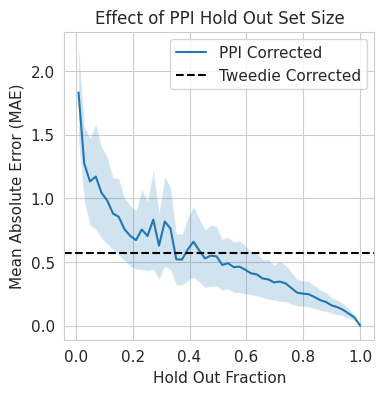

In [38]:
from matplotlib.lines import Line2D

g = plt.figure(figsize=(4, 4))

ppi_trials_stats = ppi_trials_df.drop(columns=['funder', 'ad_sector_codes', 'treated_count', 'control_count']).mean().reset_index()
ppi_trials_stats.columns = ['hold_out_frac', 'mae']
var = ppi_trials_df.drop(columns=['funder', 'ad_sector_codes', 'treated_count', 'control_count']).var().values
ppi_trials_stats['var'] = var

# Get a 95% confidence interval
ppi_trials_stats['ci'] = 1.96 * np.sqrt(ppi_trials_stats['var'] / len(ppi_trials_df))
ppi_trials_stats['ci_lower'] = ppi_trials_stats['mae'] - ppi_trials_stats['ci']
ppi_trials_stats['ci_upper'] = ppi_trials_stats['mae'] + ppi_trials_stats['ci']

g = plt.figure(figsize=(4, 4))
font_size = 11

# Plot MAE
sns.lineplot(data=ppi_trials_stats, x='hold_out_frac', y='mae')
plt.fill_between(ppi_trials_stats['hold_out_frac'], ppi_trials_stats['ci_lower'], ppi_trials_stats['ci_upper'], alpha=0.2)

tweedie_mae = mean_absolute_error(plot_df['ate'].values, plot_df['tweedie_ate_train_train'].values)
plt.axhline(tweedie_mae, color='black', linestyle='--', label='Tweedie Train MAE')

# Create custom legend handles using actual line colors
ppi_line_color = g.axes[0].lines[0].get_color()
custom_lines = [
    Line2D([0], [0], color=ppi_line_color, linestyle='-', label='PPI Corrected'),
    Line2D([0], [0], color='black', linestyle='--', label="Tweedie Corrected")
]

# Add a title
plt.title('Effect of PPI Hold Out Set Size')
plt.legend(handles=custom_lines, fontsize=font_size)

plt.xlabel('Hold Out Fraction', fontsize=font_size)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=font_size)
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)

# Save figure as ppi_vs_tweedie.png
plt.savefig('figures/ppi_vs_tweedie.png', bbox_inches='tight', dpi=300)

## Use with confounders

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def get_propensity_scores(treated_df, control_df):
    
    treated_df['treated'] = True
    control_df['treated'] = False
    trial_df = pd.concat([treated_df, control_df], axis=0)

    # Step 1: Encode categorical variables
    X = trial_df[['country', 'rural', 'year']]

    # One-hot encode country
    X_encoded = pd.get_dummies(X, columns=['country'], drop_first=True)

    # Step 2: Estimate propensity scores using logistic regression
    model = LogisticRegression(max_iter=1000)
    model.fit(X_encoded, trial_df['treated'])
    propensity_scores = model.predict_proba(X_encoded)[:, 1]

    trial_df['e'] = propensity_scores

    return trial_df

def hajek_estimator(trial_df, variable='iwi'):

    # Step 3: Calculate Hájek weights
    treated = trial_df['treated'].values
    Y = trial_df[variable].values
    e = trial_df['e'].values

    # Prevent division by zero
    e = np.clip(e, 1e-3, 1 - 1e-3)

    # Numerators and denominators
    treated_weight_num = np.sum((treated * Y) / e)
    treated_weight_den = np.sum(treated / e)

    control_weight_num = np.sum(((1 - treated) * Y) / (1 - e))
    control_weight_den = np.sum((1 - treated) / (1 - e))

    # Hájek estimator
    ATE_hajek = (treated_weight_num / treated_weight_den) - (control_weight_num / control_weight_den)
    return ATE_hajek


def get_treatment_probability(treated_df, control_df):
    
    treated_df['treated'] = True
    control_df['treated'] = False

    # Add rural confounder
    trial_df = pd.concat([treated_df, control_df], axis=0)

    X = trial_df[['country', 'rural', 'year']]
    y = trial_df['treated']

    # 2. Set up preprocessing for categorical variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), ['country'])  # drop first to avoid multicollinearity
        ],
        remainder='passthrough'  # keep 'rural' as is
    )

    # 3. Build pipeline: preprocess + logistic regression
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE+2))
    ])

    # 4. Fit the model
    model.fit(X, y)

    # 5. Get treatment probabilities (propensity scores)
    trial_df['p_of_T'] = model.predict_proba(X)[:, 1]
    
    return trial_df

In [10]:
def get_ates_of_trial_with_confounders(row, interventions_df, dhs_df):
    ad_sector_code = row['ad_sector_codes']
    funder = row['funder']

    intervention_df = interventions_df[(interventions_df['ad_sector_codes'] == ad_sector_code) & (interventions_df['funder'] == funder)]

    intervention_location_ids = intervention_df['project_location_id'].unique()

    intervention_dhs_link_df = interventions_dhs_link_df[interventions_dhs_link_df['project_location_id'].isin(intervention_location_ids)]
    valid_dhs_clusters = intervention_dhs_link_df[['cluster_id', 'years_since_intervention']].drop_duplicates()

    # The maximum and minimum years since the intervention start that we want to include to count as treated
    min_years = 3
    max_years = 8

    valid_dhs_cluster_ids = valid_dhs_clusters[valid_dhs_clusters['years_since_intervention'].between(min_years, max_years)]['cluster_id'].unique()
    treated_clusters_ixs = dhs_df['cluster_id'].isin(valid_dhs_cluster_ids)
    treated_df = dhs_df[treated_clusters_ixs]

    surveys_in_treated_df = treated_df['survey'].unique()
    control_clusters_ixs = (dhs_df['survey'].isin(surveys_in_treated_df)) & ~treated_clusters_ixs
    control_df = dhs_df[control_clusters_ixs]

    if len(treated_df) < 1 or len(control_df) < 1:
        print(f"Skipping trial {row['funder']} - {row['ad_sector_codes']} due to insufficient data.")
        row['treated_count'] = len(treated_df)
        row['control_count'] = len(control_df)
        return row

    trial_df = get_propensity_scores(treated_df, control_df)

    # Compute corrections
    trial_df['tweedie_hat'] = trial_df.apply(lambda row: row['iwi_hat'] - correction_values[row['cv_fold']]['train_sigma']**2 * row['train_score'], axis=1)
    trial_df['lcc_hat'] = trial_df.apply(lambda row: row['iwi_hat'] / correction_values[row['cv_fold']]['val_lcc_slope'], axis=1)

    # Calculate the Hájek estimator
    ate = hajek_estimator(trial_df, variable='iwi')
    ate_hat = hajek_estimator(trial_df, variable='iwi_hat')
    tweedie_ate = hajek_estimator(trial_df, variable='tweedie_hat')
    lcc_ate = hajek_estimator(trial_df, variable='lcc_hat')
    ratledge_ate = hajek_estimator(trial_df, variable='ratledge_iwi_hat')

    row['ate_iptw'] = ate
    row['ate_hat_iptw'] = ate_hat
    row['ate_hat_tweedie_iptw'] = tweedie_ate
    row['ate_hat_lcc_iptw'] = lcc_ate
    row['treated_count'] = len(treated_df)
    row['control_count'] = len(control_df)
    row['ratledge_ate'] = ratledge_ate

    return row

# Get ATEs for all trials
out_trials_df = trials_df.progress_apply(get_ates_of_trial_with_confounders, axis=1, interventions_df=interventions_df, dhs_df=dhs_df)
out_trials_df

 59%|█████▉    | 20/34 [00:04<00:01,  8.61it/s]

Skipping trial CH - 998 due to insufficient data.


100%|██████████| 34/34 [00:13<00:00,  2.52it/s]


,ad_sector_codes,ad_sector_names,ate_hat_iptw,ate_hat_lcc_iptw,ate_hat_tweedie_iptw,ate_iptw,control_count,funder,ratledge_ate,treated_count
0,230,Energy Generation and Supply,-0.652698,-0.828159,-1.081926,3.035670,7958,CH,-0.670201,357
1,220,Communications,3.028438,3.705450,3.922745,3.869894,6371,CH,5.519162,997
2,210,Transport and Storage,4.773907,6.050785,4.945456,5.389483,14122,CH,5.025261,1509
3,110,Education,7.835154,9.878440,8.433654,8.256850,22381,CH,9.949094,1549
4,150,Government and Civil Society,11.229308,14.113947,11.910361,14.778705,22983,CH,14.227944,1860
5,320,"Industry, Mining, Construction",7.858142,9.888632,8.515137,4.417761,2041,CH,11.384889,74
6,310,"Agriculture, Forestry and Fishing",5.320952,6.771052,4.976840,6.707696,10400,CH,4.859754,949
7,120,Health,7.916517,9.976819,8.602845,8.587879,32198,CH,8.941825,3333
8,520,Developmental Food Aid/Food Security Assistance,7.858206,9.957180,9.328431,6.213114,2163,CH,10.556026,170
9,140,Water Supply and Sanitation,2.167179,2.808844,2.086531,-0.455626,7883,CH,0.871354,676


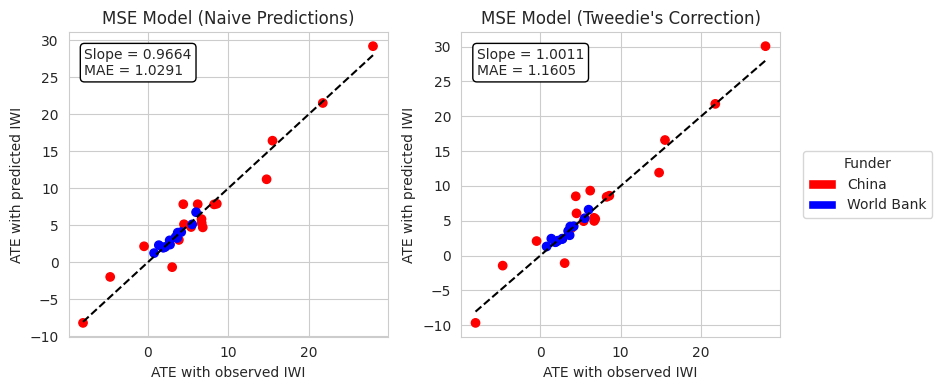

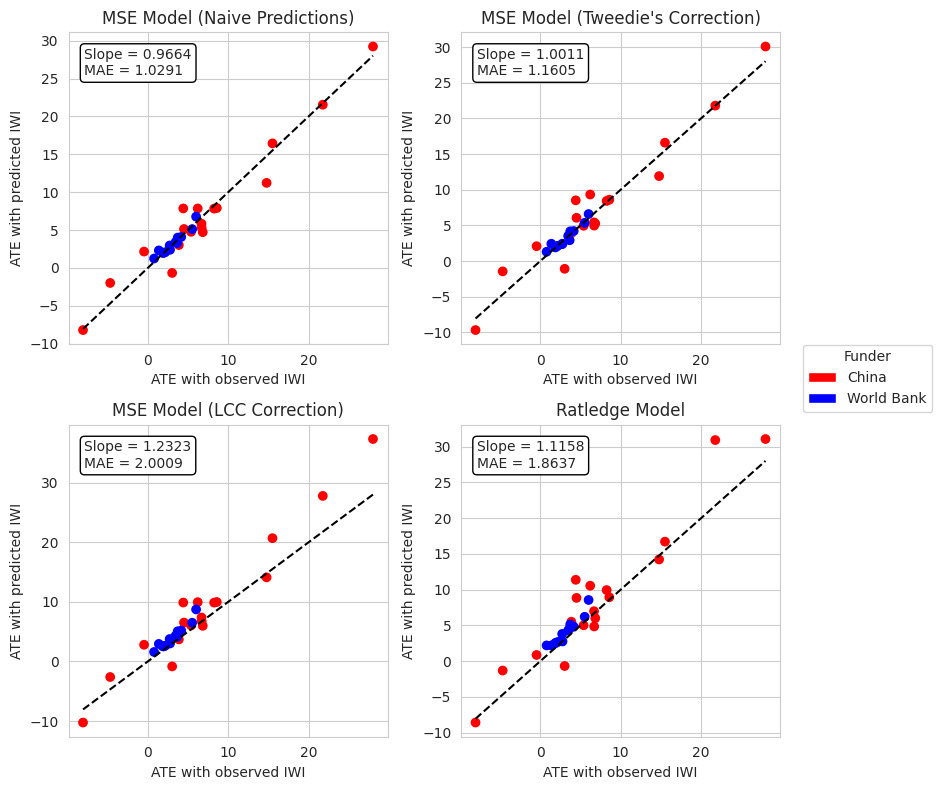

In [14]:
from matplotlib.patches import Patch

def plot_ate_iptw_scatter(plot_df, predicted_col, title, axis_min=-1, axis_max=28):

    plt.scatter(plot_df['ate_iptw'].values, plot_df[predicted_col].values.astype(float), c=plot_df['funder'].map({'CH': 'red', 'WB': 'blue'}))
    # Add label with slope and MAE to plot
    slope, _ = np.polyfit(plot_df['ate_iptw'].values, plot_df[predicted_col].values.astype(float), 1)
    mae = mean_absolute_error(plot_df['ate_iptw'].values, plot_df[predicted_col].values)
    plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    plt.plot([plot_df['ate_iptw'].min(), plot_df['ate_iptw'].max()],
             [plot_df['ate_iptw'].min(), plot_df['ate_iptw'].max()], 'k--')
    plt.xlabel('ATE with observed IWI')
    plt.ylabel('ATE with predicted IWI')
    plt.title(title)

    if axis_min is not None and axis_max is not None:
        plt.xlim(axis_min, axis_max)
        plt.ylim(axis_min, axis_max)

def plot_ate_iptw_scatter_weighted(plot_df, predicted_col, title, axis_min=-1, axis_max=28):
    # Extract treated_count for weighting
    weights = plot_df['treated_count'].values

    # Scatter plot with weighted points (size of points based on 'treated_count')
    scatter = plt.scatter(plot_df['ate_iptw'].values, 
                          plot_df[predicted_col].values.astype(float), 
                          c=plot_df['funder'].map({'CH': 'red', 'WB': 'blue'}),
                          s=weights/100, alpha=0.5)  # Adjust alpha for better visibility
    
    # Add label with weighted slope and MAE to plot
    slope, intercept = np.polyfit(plot_df['ate_iptw'].values, 
                                  plot_df[predicted_col].values.astype(float), 
                                  1, w=weights)  # Apply weights here
    
    mae = mean_absolute_error(plot_df['ate_iptw'].values, plot_df[predicted_col].values)
    
    plt.text(0.05, 0.95, f'Slope = {slope:.4f}\nMAE = {mae:.4f}', 
             transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    
    # Add identity line
    plt.plot([plot_df['ate_iptw'].min(), plot_df['ate_iptw'].max()],
             [plot_df['ate_iptw'].min(), plot_df['ate_iptw'].max()], 'k--')
    
    plt.xlabel('ATE with observed IWI')
    plt.ylabel('ATE with predicted IWI')
    plt.title(title)

    if axis_min is not None and axis_max is not None:
        plt.xlim(axis_min, axis_max)
        plt.ylim(axis_min, axis_max)


# Plot the ATEs
plot_df = out_trials_df.dropna()
plot_df = plot_df[plot_df['treated_count'] > 10]
#plot_df = plot_df[plot_df['ate_iptw'] < 10]
#plot_df = plot_df[plot_df['funder'] == 'WB']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_ate_iptw_scatter(plot_df, 'ate_hat_iptw', "MSE Model (Naive Predictions)", axis_min=None, axis_max=None)

plt.subplot(1, 2, 2)
plot_ate_iptw_scatter(plot_df, 'ate_hat_tweedie_iptw', "MSE Model (Tweedie's Correction)", axis_min=None, axis_max=None)
plt.tight_layout()

legend_elements = [
    Patch(facecolor='red', label='China'),
    Patch(facecolor='blue', label='World Bank')
]
plt.legend(handles=legend_elements, title='Funder', loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plot_ate_iptw_scatter(plot_df, 'ate_hat_iptw', "MSE Model (Naive Predictions)", axis_min=None, axis_max=None)

plt.subplot(2, 2, 2)
plot_ate_iptw_scatter(plot_df, 'ate_hat_tweedie_iptw', "MSE Model (Tweedie's Correction)", axis_min=None, axis_max=None)

plt.subplot(2, 2, 3)
plot_ate_iptw_scatter(plot_df, 'ate_hat_lcc_iptw', "MSE Model (LCC Correction)", axis_min=None, axis_max=None)

plt.subplot(2, 2, 4)
plot_ate_iptw_scatter(plot_df, 'ratledge_ate', "Ratledge Model", axis_min=None, axis_max=None)

plt.tight_layout()

legend_elements = [
    Patch(facecolor='red', label='China'),
    Patch(facecolor='blue', label='World Bank')
]
plt.legend(handles=legend_elements, title='Funder', loc='center left', bbox_to_anchor=(1.05, 1.15))
plt.show()